In [3]:
import pandas as pd
import numpy as np
import math
import random
import seaborn as sns
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal

studentData = pd.read_csv('Data/student-mat.csv')
studentData.dropna
studentData

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [4]:
# randomly pick 1000 student data
from sklearn.utils import shuffle
student_1000 = shuffle(studentData)[:1000]
student_1000

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
288,GP,M,18,U,GT3,T,2,1,services,services,...,4,2,4,1,3,2,6,15,14,14
117,GP,M,16,U,GT3,T,3,3,other,services,...,5,4,2,1,1,5,0,13,14,13
207,GP,F,16,U,GT3,T,4,3,teacher,other,...,1,3,2,1,1,1,10,11,12,13
123,GP,M,16,U,GT3,T,4,4,health,other,...,3,4,4,1,4,5,18,14,11,13
44,GP,F,16,U,LE3,T,2,2,other,at_home,...,4,3,3,2,2,5,14,10,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,GP,F,17,U,GT3,T,4,2,other,other,...,4,3,3,1,1,3,0,15,12,14
89,GP,M,16,U,LE3,A,4,4,teacher,health,...,4,1,3,3,5,5,18,8,6,7
336,GP,F,19,R,GT3,A,3,1,services,at_home,...,5,4,3,1,2,5,12,14,13,13
173,GP,F,16,U,GT3,T,1,3,at_home,services,...,4,3,5,1,1,3,0,8,7,0


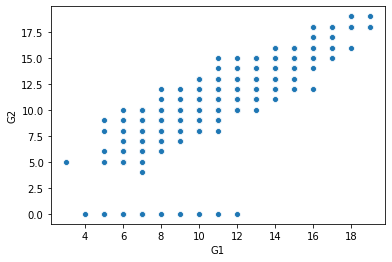

In [5]:
sns.scatterplot(data=student_1000, x='G1', y='G2')

# Gaussian Mixture Model

I will use Gaussian Mixture Model to different clusters based on the similarity. My clusters are based on two of the features (i.e. G1 / G2, which are the grades from two exams).

In [6]:
def gaussian(sample,mu,sigma):
    x = np.array(sample)
    D = len(x)
    exp_part = np.exp(-(1/2)*np.matmul(np.matmul((x-mu),np.linalg.inv(sigma)),(x-mu).T))
    N = (1/math.sqrt(((2*np.pi)**D)*np.linalg.det(sigma)))
    gaussian_value = N * exp_part
    return gaussian_value

# Implementing Expectation-Maximization Algorithm for GMM

First is the expectation step

In [7]:
def E_step(sample,param,K):
    mu = np.array(param['mu'])
    sigma = np.array(param['sigma'])
    phi = np.array(param['phi'])
    
    x = np.array(sample)
    D = len(x)
    probability = np.zeros((D,K))
    label = [] # label of each clusters
    for i in range(D):
        for k in range(K):
            bottum_total = 0
            for j in range(K):
                bottum_total += phi[j] * gaussian(x[i],mu[j],sigma[j])
            probability[i][k] = phi[k] * gaussian(x[i],mu[k],sigma[k]) / bottum_total
        max_prob = max(probability[i])
        label.append(list(probability[i]).index(max_prob))
    
    sample['Label'] = label
    return probability,sample

Upload the data with only two features

In [8]:
student_2_feature = student_1000[['G1','G2']]
student_2_feature

,G1,G2
288,15,14
117,13,14
207,11,12
123,14,11
44,10,10
...,...,...
302,15,12
89,8,6
336,14,13
173,8,7


Maximization step to get optimal parameter (mu,sigma,phi)

In [9]:
def M_step(sample,probability,param,K):
    x = np.array(sample)
    D = len(x)
    new_phi = []
    new_mu = []
    new_sigma = []
    
    old_mu = np.array(param['mu'])
    
    mu_sum = 0
    sigma_sum = 0
    
    for k in range(K):
        prob_sum = 0
        for i in range(D):
            prob_sum += probability[i][k]
            mu_sum += probability[i][k] * x[i]
            diff = (x[i] - old_mu[k]).reshape(-1,1)
            sigma_sum += probability[i][k] * np.matmul((diff),(diff).T)
        new_phi.append(prob_sum / D)
        new_mu.append(mu_sum / prob_sum)
        new_sigma.append(sigma_sum / prob_sum)
        
    param['mu'] = new_mu
    param['sigma'] = new_sigma
    param['phi'] = new_phi
    return param

Calculate the likelihood function

In [10]:
def likelihood(sample,param,K):
    mu = np.array(param['mu'])
    sigma = np.array(param['sigma'])
    phi = np.array(param['phi'])
    
    x = np.array(sample)
    D = len(x)
    
    likelihood = 0
    for i in range(D):
        cluster_sum = 0
        for k in range(K):
            cluster_sum += phi[k] * gaussian(x[i],mu[k],sigma[k])
            
        likelihood = likelihood + math.log1p(cluster_sum)
        
    return likelihood

# Now implementing GMM model

There still a problem exist in my GMM model (same problem with wine-quality data). My model is not able to converge, and while more iteration I run, some value of mu, or sigma will be very large to infinite, which is not expected. I think it might be some problem with initization of those parameters, however, I am stuck in fix the problem. 

I then only run with 1 iteration, and the final result (clustering) looks good that the data is clustered to different groups based on the similarities

In [11]:
def GMM(sample,K,epsilon = 0.01,num_iter = 1):
    # initialize mu,sigma,phi
    [n,p] = sample.shape
    mu = []
    sigma = []
    phi = []
    for k in range(K):
        mu.append(np.array(sample)[random.randrange(n),:])
        sigma.append(np.eye(p))
        phi.append((1/K))
        
    initial_params = {'mu':mu,'sigma':sigma,'phi':phi}
    params = pd.DataFrame.from_dict(initial_params)
    old_likelihood = likelihood(sample,params,K)
    converge = False
    itera = 0
    while converge == False and itera < num_iter:
        probability, sample_with_label = E_step(sample.copy(),params,K)
        new_params = M_step(sample,probability,params.copy(),K)
        
        # test for converge
        new_likelihood = likelihood(sample,new_params,K)
        if (abs(new_likelihood-old_likelihood) < epsilon):
            converge = True
        params = new_params
        old_likelihood = new_likelihood
        itera += 1
        
    return params,sample_with_label

2 clusters 

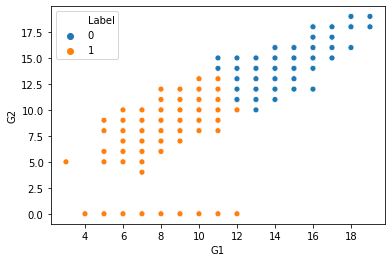

In [13]:
pram, sample_done = GMM(student_2_feature,2)

sns.scatterplot(data=sample_done, x='G1', y='G2',hue='Label')

3 clusters

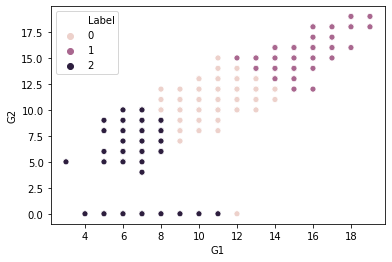

In [14]:
pram, sample_done = GMM(student_2_feature,3)

sns.scatterplot(data=sample_done, x='G1', y='G2',hue='Label')